<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/optuna_and_bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 8th July, 2021
# Myfolder: C:\Users\Administrator\OneDrive\Documents\breast_cancer
#
# Ref: https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
#      https://github.com/optuna/optuna/blob/master/examples/lightgbm_tuner_simple.py
#
# Objective:
#           i) Learn to use automated tuning of lightgbm
#          ii) Using optuna
#         iii) Perform Bayesian optimization
#          iv) Optimizing Pipeline
#
# See also 'h2o_talkingData.ipynb' in folder:
#   C:\Users\Administrator\OneDrive\Documents\talkingdata

In [ ]:
"""
Optuna example that optimizes a classifier configuration
using LightGBM tuner.
In this example, we optimize the validation log loss

"""

### Install libraries

In [43]:
# 0.0 Downgrade sklearn
#     Higher version gives problem with BayesSearchCV (skopt)
#     conda install -c intel scikit-learn==0.23.2

! pip install scikit-learn==0.23.2 
import sklearn
sklearn.__version__

'0.23.2'

In [44]:
# 0.1 Optuna
#     https://optuna.org/
! pip install optuna

In [ ]:
# 0.2 sklearn optimizer
# 
!pip install scikit-optimize
!pip install 'scikit-optimize[plots]'

In [ ]:
# 0.3 Lightgbm
! pip install lightgbm --upgrade
import lightgbm
lightgbm.__version__

### Call libraries

In [47]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import sklearn.datasets
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 1.1 Import optuna integration with lightgbm
# Install as: conda install -c conda-forge optuna
import optuna.integration.lightgbm as lgbm


# 1.2  Return stratified folds. The folds are made by
#      preserving the percentage of samples for each class.

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve

# 1.3 ML - we will classify using lightgbm
#          with stratified cross validation
#          conda install -c conda-forge lightgbm 
import lightgbm as lgb

# 1.4 OS related
import os, time

# 1.5 Bayes optimization--IInd method
# SKOPT is a parameter-optimisation framewor
#  Install skopt as:
#     conda install -c conda-forge scikit-optimize

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# 1.6
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [48]:
# 1.7
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read data

In [49]:
# # 2.0 Get data and split it
data,target = make_classification(  n_samples = 10000,
                                    n_features = 25,
                                    n_informative = 20,
                                    n_redundant = 2,
                                    n_repeated = 3,
                                    n_classes = 2,
                                    flip_y = 0.01,
                                    shuffle = True
                                  )

#### Create some categorical features

In [50]:
# 2.1 Transform to pandas dataframe
df = pd.DataFrame(data, columns = ["c" + str(i) for i in range(25)])
df.head(2)

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24
0,0.374429,-3.801091,-0.792911,2.253009,-1.052819,-1.917159,1.327901,2.253009,-2.047104,1.803323,-2.395860,0.600562,-2.253816,-1.560202,0.351420,-0.765896,1.117091,-2.594506,-2.931400,-4.486719,-2.668279,-3.082582,1.327901,0.821409,-0.792911
1,0.764841,1.651728,9.845462,0.658744,3.945355,-0.226803,2.590126,0.658744,0.839470,-4.099876,-0.524466,-4.554815,1.412110,-2.944011,-2.113245,-3.489946,4.068615,1.210525,-0.750784,-2.363587,-3.876824,-0.648575,2.590126,2.527653,9.845462


In [51]:
# 2.2 To discrete

df["c0"] = pd.cut(df["c0"], 3, labels = ["l", "m", "h"])
df["c1"] = pd.qcut(df["c1"], [0.0,0.25,0.50,0.75,1], labels = ["l", "m", "h", "vh"])
df.head(2)

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24
0,m,l,-0.792911,2.253009,-1.052819,-1.917159,1.327901,2.253009,-2.047104,1.803323,-2.395860,0.600562,-2.253816,-1.560202,0.351420,-0.765896,1.117091,-2.594506,-2.931400,-4.486719,-2.668279,-3.082582,1.327901,0.821409,-0.792911
1,m,vh,9.845462,0.658744,3.945355,-0.226803,2.590126,0.658744,0.839470,-4.099876,-0.524466,-4.554815,1.412110,-2.944011,-2.113245,-3.489946,4.068615,1.210525,-0.750784,-2.363587,-3.876824,-0.648575,2.590126,2.527653,9.845462


#### Transform cat features to integers
Using map() or LabelEncoder()

In [52]:
# 2.3
df["c0"] = df["c0"].map({"l" : "0", "m" : "1", "h" : "2"})
df["c1"] = df["c1"].map({"l" : "0", "m" : "1", "h" : "2", "vh" : "3"})
df.head(2)

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24
0,1,0,-0.792911,2.253009,-1.052819,-1.917159,1.327901,2.253009,-2.047104,1.803323,-2.395860,0.600562,-2.253816,-1.560202,0.351420,-0.765896,1.117091,-2.594506,-2.931400,-4.486719,-2.668279,-3.082582,1.327901,0.821409,-0.792911
1,1,3,9.845462,0.658744,3.945355,-0.226803,2.590126,0.658744,0.839470,-4.099876,-0.524466,-4.554815,1.412110,-2.944011,-2.113245,-3.489946,4.068615,1.210525,-0.750784,-2.363587,-3.876824,-0.648575,2.590126,2.527653,9.845462


In [56]:
# 2.4
train_x, val_x, train_y, val_y = train_test_split(
                                                  data,
                                                  target,
                                                  test_size=0.25,
                                                  shuffle=True,
                                                  stratify = target
                                                  )

train_x.shape  # 7500, 25)
val_x.shape    # (2500, 25)

(7500, 25)

(2500, 25)

## Optuna lightgbm modeling

#### Transform data to lgbm data format

In [63]:
# 2.1 Transform train_x and val_x to lightgbm data-matricies
# Ref: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html

dtrain = lgbm.Dataset(train_x,
                      label=train_y,
                      categorical_feature = [0,1]
                      )

dval = lgbm.Dataset(
                     val_x,
                     label=val_y,
                     categorical_feature = [0,1]
                    )

### Declare fixed parameters

In [64]:
# 3.0 Set fixed hyper-params
params_fixed = {                           # Specify params that are fixed
                 "objective": "binary",
                 "metric": "binary_logloss",
                 "verbosity": -1,
                 "boosting_type": "gbdt",
                }

### Build model for tuning
Tune hyperparameters

In [67]:
# 3.1 Note that unlike in sklearn, here there is
#     no instantiation of LightGBM model
#     Start modeling as also tuning hyperparameters

model = lgbm.train(
                   params_fixed,               # Just fixed params only
                   dtrain,                     # Dataset
                   valid_sets=[dtrain, dval],  # Evaluate performance on these datasets
                   verbose_eval=100,
                   early_stopping_rounds=100,
                   categorical_feature = [0,1] # columns 0 and 1 are categorical
                  )


[I 2021-07-08 14:38:12,428] A new study created in memory with name: no-name-ef097d50-4749-4397-9166-12d798c3685f


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1433: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1245: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0734411	valid_1's binary_logloss: 0.169354
[200]	valid_0's binary_logloss: 0.0219475	valid_1's binary_logloss: 0.135854
[300]	valid_0's binary_logloss: 0.00641305	valid_1's binary_logloss: 0.127846
[400]	valid_0's binary_logloss: 0.0019557	valid_1's binary_logloss: 0.12864
Early stopping, best iteration is:
[343]	valid_0's binary_logloss: 0.00382634	valid_1's binary_logloss: 0.126784




feature_fraction, val_score: 0.126784:   0%|          | 0/7 [00:02<?, ?it/s]

feature_fraction, val_score: 0.126784:  14%|#4        | 1/7 [00:02<00:13,  2.24s/it][I 2021-07-08 14:38:14,691] Trial 0 finished with value: 0.1267842635946944 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.1267842635946944.


feature_fraction, val_score: 0.126784:  14%|#4        | 1/7 [00:02<00:13,  2.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0815043	valid_1's binary_logloss: 0.174535
[200]	valid_0's binary_logloss: 0.0247984	valid_1's binary_logloss: 0.1373
[300]	valid_0's binary_logloss: 0.0076537	valid_1's binary_logloss: 0.1277




feature_fraction, val_score: 0.126784:  14%|#4        | 1/7 [00:04<00:13,  2.24s/it]

[400]	valid_0's binary_logloss: 0.00244222	valid_1's binary_logloss: 0.129646
Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 0.00520264	valid_1's binary_logloss: 0.126903




feature_fraction, val_score: 0.126784:  29%|##8       | 2/7 [00:04<00:10,  2.15s/it][I 2021-07-08 14:38:16,630] Trial 1 finished with value: 0.12690329256169067 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.1267842635946944.


feature_fraction, val_score: 0.126784:  29%|##8       | 2/7 [00:04<00:10,  2.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0753099	valid_1's binary_logloss: 0.170099
[200]	valid_0's binary_logloss: 0.0224402	valid_1's binary_logloss: 0.135378
[300]	valid_0's binary_logloss: 0.00687582	valid_1's binary_logloss: 0.130473




feature_fraction, val_score: 0.126784:  29%|##8       | 2/7 [00:06<00:10,  2.15s/it]

feature_fraction, val_score: 0.126784:  43%|####2     | 3/7 [00:06<00:08,  2.05s/it][I 2021-07-08 14:38:18,459] Trial 2 finished with value: 0.1296152922430984 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.1267842635946944.


feature_fraction, val_score: 0.126784:  43%|####2     | 3/7 [00:06<00:08,  2.05s/it]

Early stopping, best iteration is:
[281]	valid_0's binary_logloss: 0.00855108	valid_1's binary_logloss: 0.129615
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.085826	valid_1's binary_logloss: 0.180323
[200]	valid_0's binary_logloss: 0.0258896	valid_1's binary_logloss: 0.139373
[300]	valid_0's binary_logloss: 0.00840677	valid_1's binary_logloss: 0.128006
[400]	valid_0's binary_logloss: 0.00283854	valid_1's binary_logloss: 0.128796
Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.00452298	valid_1's binary_logloss: 0.126977




feature_fraction, val_score: 0.126784:  43%|####2     | 3/7 [00:07<00:08,  2.05s/it]

feature_fraction, val_score: 0.126784:  57%|#####7    | 4/7 [00:07<00:05,  1.99s/it][I 2021-07-08 14:38:20,307] Trial 3 finished with value: 0.12697693147635633 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.1267842635946944.


feature_fraction, val_score: 0.126784:  57%|#####7    | 4/7 [00:07<00:05,  1.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0995609	valid_1's binary_logloss: 0.193448
[200]	valid_0's binary_logloss: 0.0326545	valid_1's binary_logloss: 0.150385
[300]	valid_0's binary_logloss: 0.0115918	valid_1's binary_logloss: 0.140103
[400]	valid_0's binary_logloss: 0.00407212	valid_1's binary_logloss: 0.134719




feature_fraction, val_score: 0.126784:  57%|#####7    | 4/7 [00:09<00:05,  1.99s/it]

feature_fraction, val_score: 0.126784:  71%|#######1  | 5/7 [00:09<00:03,  1.93s/it][I 2021-07-08 14:38:22,095] Trial 4 finished with value: 0.13450524097571184 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.1267842635946944.


feature_fraction, val_score: 0.126784:  71%|#######1  | 5/7 [00:09<00:03,  1.93s/it]

Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.00423043	valid_1's binary_logloss: 0.134505
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0700553	valid_1's binary_logloss: 0.166767
[200]	valid_0's binary_logloss: 0.0205571	valid_1's binary_logloss: 0.135652
[300]	valid_0's binary_logloss: 0.00589423	valid_1's binary_logloss: 0.127932




feature_fraction, val_score: 0.126784:  71%|#######1  | 5/7 [00:11<00:03,  1.93s/it]

feature_fraction, val_score: 0.126784:  86%|########5 | 6/7 [00:11<00:01,  1.98s/it][I 2021-07-08 14:38:24,196] Trial 5 finished with value: 0.12724253326302884 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.1267842635946944.


feature_fraction, val_score: 0.126784:  86%|########5 | 6/7 [00:11<00:01,  1.98s/it]

Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.00615239	valid_1's binary_logloss: 0.127243
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0670125	valid_1's binary_logloss: 0.16539
[200]	valid_0's binary_logloss: 0.0194083	valid_1's binary_logloss: 0.134453
[300]	valid_0's binary_logloss: 0.00558446	valid_1's binary_logloss: 0.127161
[400]	valid_0's binary_logloss: 0.00161757	valid_1's binary_logloss: 0.12754
Early stopping, best iteration is:
[325]	valid_0's binary_logloss: 0.00406154	valid_1's binary_logloss: 0.125871




feature_fraction, val_score: 0.125871:  86%|########5 | 6/7 [00:14<00:01,  1.98s/it]

feature_fraction, val_score: 0.125871: 100%|##########| 7/7 [00:14<00:00,  2.07s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.125871:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.122558	valid_1's binary_logloss: 0.196284
[200]	valid_0's binary_logloss: 0.0606385	valid_1's binary_logloss: 0.157312
[300]	valid_0's binary_logloss: 0.0315356	valid_1's binary_logloss: 0.140372
[400]	valid_0's binary_logloss: 0.0160659	valid_1's binary_logloss: 0.131887
[500]	valid_0's binary_logloss: 0.0079806	valid_1's binary_logloss: 0.127515




num_leaves, val_score: 0.125871:   0%|          | 0/20 [00:02<?, ?it/s]

num_leaves, val_score: 0.125871:   5%|5         | 1/20 [00:02<00:46,  2.44s/it][I 2021-07-08 14:38:29,415] Trial 7 finished with value: 0.12657231999335303 and parameters: {'num_leaves': 18}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:   5%|5         | 1/20 [00:02<00:46,  2.44s/it]

[600]	valid_0's binary_logloss: 0.00397002	valid_1's binary_logloss: 0.128906
Early stopping, best iteration is:
[525]	valid_0's binary_logloss: 0.00666372	valid_1's binary_logloss: 0.126572
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0108524	valid_1's binary_logloss: 0.138396
[200]	valid_0's binary_logloss: 0.000440132	valid_1's binary_logloss: 0.141241




num_leaves, val_score: 0.125871:   5%|5         | 1/20 [00:05<00:46,  2.44s/it]

num_leaves, val_score: 0.125871:  10%|#         | 2/20 [00:05<00:46,  2.56s/it][I 2021-07-08 14:38:32,270] Trial 8 finished with value: 0.13322047677518775 and parameters: {'num_leaves': 84}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  10%|#         | 2/20 [00:05<00:46,  2.56s/it]

Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.0032808	valid_1's binary_logloss: 0.13322
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00212958	valid_1's binary_logloss: 0.150486




num_leaves, val_score: 0.125871:  10%|#         | 2/20 [00:10<00:46,  2.56s/it]

num_leaves, val_score: 0.125871:  15%|#5        | 3/20 [00:10<00:54,  3.23s/it][I 2021-07-08 14:38:37,062] Trial 9 finished with value: 0.1482797514383973 and parameters: {'num_leaves': 247}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  15%|#5        | 3/20 [00:10<00:54,  3.23s/it]

Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.00382736	valid_1's binary_logloss: 0.14828
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00211612	valid_1's binary_logloss: 0.147665




num_leaves, val_score: 0.125871:  15%|#5        | 3/20 [00:14<00:54,  3.23s/it]

num_leaves, val_score: 0.125871:  20%|##        | 4/20 [00:14<00:58,  3.66s/it][I 2021-07-08 14:38:41,710] Trial 10 finished with value: 0.1471102664512484 and parameters: {'num_leaves': 224}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  20%|##        | 4/20 [00:14<00:58,  3.66s/it]

Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.00291103	valid_1's binary_logloss: 0.14711
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00210409	valid_1's binary_logloss: 0.145497




num_leaves, val_score: 0.125871:  20%|##        | 4/20 [00:19<00:58,  3.66s/it]

num_leaves, val_score: 0.125871:  25%|##5       | 5/20 [00:19<00:59,  3.95s/it][I 2021-07-08 14:38:46,356] Trial 11 finished with value: 0.14500972600735873 and parameters: {'num_leaves': 238}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  25%|##5       | 5/20 [00:19<00:59,  3.95s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.00420935	valid_1's binary_logloss: 0.14501
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0343881	valid_1's binary_logloss: 0.14817
[200]	valid_0's binary_logloss: 0.00456805	valid_1's binary_logloss: 0.130268
[300]	valid_0's binary_logloss: 0.000722008	valid_1's binary_logloss: 0.135967
Early stopping, best iteration is:
[218]	valid_0's binary_logloss: 0.00316894	valid_1's binary_logloss: 0.129172




num_leaves, val_score: 0.125871:  25%|##5       | 5/20 [00:22<00:59,  3.95s/it]

num_leaves, val_score: 0.125871:  30%|###       | 6/20 [00:22<00:51,  3.64s/it][I 2021-07-08 14:38:49,272] Trial 12 finished with value: 0.1291718829440485 and parameters: {'num_leaves': 47}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  30%|###       | 6/20 [00:22<00:51,  3.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00212331	valid_1's binary_logloss: 0.147737




num_leaves, val_score: 0.125871:  30%|###       | 6/20 [00:26<00:51,  3.64s/it]

num_leaves, val_score: 0.125871:  35%|###5      | 7/20 [00:26<00:50,  3.90s/it][I 2021-07-08 14:38:53,785] Trial 13 finished with value: 0.14636838148698864 and parameters: {'num_leaves': 222}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  35%|###5      | 7/20 [00:26<00:50,  3.90s/it]

Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.00358242	valid_1's binary_logloss: 0.146368
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0721582	valid_1's binary_logloss: 0.168146
[200]	valid_0's binary_logloss: 0.0226782	valid_1's binary_logloss: 0.137222
[300]	valid_0's binary_logloss: 0.00694207	valid_1's binary_logloss: 0.128063




num_leaves, val_score: 0.125871:  35%|###5      | 7/20 [00:29<00:50,  3.90s/it]

num_leaves, val_score: 0.125871:  40%|####      | 8/20 [00:29<00:40,  3.40s/it][I 2021-07-08 14:38:56,013] Trial 14 finished with value: 0.1268565163771056 and parameters: {'num_leaves': 29}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  40%|####      | 8/20 [00:29<00:40,  3.40s/it]

[400]	valid_0's binary_logloss: 0.00224423	valid_1's binary_logloss: 0.13026
Early stopping, best iteration is:
[313]	valid_0's binary_logloss: 0.00595857	valid_1's binary_logloss: 0.126857
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00207308	valid_1's binary_logloss: 0.146085




num_leaves, val_score: 0.125871:  40%|####      | 8/20 [00:33<00:40,  3.40s/it]

num_leaves, val_score: 0.125871:  45%|####5     | 9/20 [00:33<00:41,  3.76s/it][I 2021-07-08 14:39:00,606] Trial 15 finished with value: 0.1452964736080207 and parameters: {'num_leaves': 229}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  45%|####5     | 9/20 [00:33<00:41,  3.76s/it]

Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.00353184	valid_1's binary_logloss: 0.145296
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00738704	valid_1's binary_logloss: 0.13785
[200]	valid_0's binary_logloss: 0.000200569	valid_1's binary_logloss: 0.147984




num_leaves, val_score: 0.125871:  45%|####5     | 9/20 [00:37<00:41,  3.76s/it]

num_leaves, val_score: 0.125871:  50%|#####     | 10/20 [00:37<00:38,  3.82s/it][I 2021-07-08 14:39:04,582] Trial 16 finished with value: 0.1359759857185003 and parameters: {'num_leaves': 99}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  50%|#####     | 10/20 [00:37<00:38,  3.82s/it]

Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.00176751	valid_1's binary_logloss: 0.135976
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00260851	valid_1's binary_logloss: 0.150389




num_leaves, val_score: 0.125871:  50%|#####     | 10/20 [00:41<00:38,  3.82s/it]

num_leaves, val_score: 0.125871:  55%|#####5    | 11/20 [00:41<00:34,  3.85s/it][I 2021-07-08 14:39:08,500] Trial 17 finished with value: 0.14981533578628672 and parameters: {'num_leaves': 168}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  55%|#####5    | 11/20 [00:41<00:34,  3.85s/it]

Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.00368459	valid_1's binary_logloss: 0.149815
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.242119	valid_1's binary_logloss: 0.284466
[200]	valid_0's binary_logloss: 0.175308	valid_1's binary_logloss: 0.231566
[300]	valid_0's binary_logloss: 0.134912	valid_1's binary_logloss: 0.202879
[400]	valid_0's binary_logloss: 0.105221	valid_1's binary_logloss: 0.183483
[500]	valid_0's binary_logloss: 0.082552	valid_1's binary_logloss: 0.16795
[600]	valid_0's binary_logloss: 0.0657207	valid_1's binary_logloss: 0.15778
[700]	valid_0's binary_logloss: 0.0530545	valid_1's binary_logloss: 0.15199
[800]	valid_0's binary_logloss: 0.042326	valid_1's binary_logloss: 0.146314
[900]	valid_0's binary_logloss: 0.0338007	valid_1's binary_logloss: 0.141005
[1000]	valid_0's binary_logloss: 0.0273425	valid_1's binary_logloss: 0.139005
Did not meet early stopping. Best iteration is:
[1000]	valid_0's



num_leaves, val_score: 0.125871:  55%|#####5    | 11/20 [00:43<00:34,  3.85s/it]

num_leaves, val_score: 0.125871:  60%|######    | 12/20 [00:43<00:26,  3.36s/it][I 2021-07-08 14:39:10,726] Trial 18 finished with value: 0.1390050484917149 and parameters: {'num_leaves': 7}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  60%|######    | 12/20 [00:43<00:26,  3.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.289129	valid_1's binary_logloss: 0.321149
[200]	valid_0's binary_logloss: 0.225408	valid_1's binary_logloss: 0.268838
[300]	valid_0's binary_logloss: 0.18498	valid_1's binary_logloss: 0.23633
[400]	valid_0's binary_logloss: 0.154174	valid_1's binary_logloss: 0.212186
[500]	valid_0's binary_logloss: 0.132382	valid_1's binary_logloss: 0.198369
[600]	valid_0's binary_logloss: 0.114582	valid_1's binary_logloss: 0.18864
[700]	valid_0's binary_logloss: 0.0980433	valid_1's binary_logloss: 0.178132
[800]	valid_0's binary_logloss: 0.0855587	valid_1's binary_logloss: 0.170284
[900]	valid_0's binary_logloss: 0.0736135	valid_1's binary_logloss: 0.162715




num_leaves, val_score: 0.125871:  60%|######    | 12/20 [00:45<00:26,  3.36s/it]

num_leaves, val_score: 0.125871:  65%|######5   | 13/20 [00:45<00:20,  2.93s/it][I 2021-07-08 14:39:12,653] Trial 19 finished with value: 0.15488780789240938 and parameters: {'num_leaves': 5}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  65%|######5   | 13/20 [00:45<00:20,  2.93s/it]

[1000]	valid_0's binary_logloss: 0.062534	valid_1's binary_logloss: 0.154888
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.062534	valid_1's binary_logloss: 0.154888
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0542946	valid_1's binary_logloss: 0.159296
[200]	valid_0's binary_logloss: 0.0122362	valid_1's binary_logloss: 0.132438
[300]	valid_0's binary_logloss: 0.00287122	valid_1's binary_logloss: 0.128661




num_leaves, val_score: 0.125871:  65%|######5   | 13/20 [00:48<00:20,  2.93s/it]

num_leaves, val_score: 0.125871:  70%|#######   | 14/20 [00:48<00:16,  2.76s/it][I 2021-07-08 14:39:15,005] Trial 20 finished with value: 0.12736890756239522 and parameters: {'num_leaves': 36}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  70%|#######   | 14/20 [00:48<00:16,  2.76s/it]

Early stopping, best iteration is:
[268]	valid_0's binary_logloss: 0.00443585	valid_1's binary_logloss: 0.127369
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0262486	valid_1's binary_logloss: 0.143985
[200]	valid_0's binary_logloss: 0.00265559	valid_1's binary_logloss: 0.131761




num_leaves, val_score: 0.125871:  70%|#######   | 14/20 [00:50<00:16,  2.76s/it]

num_leaves, val_score: 0.125871:  75%|#######5  | 15/20 [00:50<00:13,  2.67s/it][I 2021-07-08 14:39:17,451] Trial 21 finished with value: 0.12987350145916515 and parameters: {'num_leaves': 54}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  75%|#######5  | 15/20 [00:50<00:13,  2.67s/it]

Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.00450925	valid_1's binary_logloss: 0.129874
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00317166	valid_1's binary_logloss: 0.140787
[200]	valid_0's binary_logloss: 3.16907e-05	valid_1's binary_logloss: 0.166684
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.00197772	valid_1's binary_logloss: 0.139581




num_leaves, val_score: 0.125871:  75%|#######5  | 15/20 [00:54<00:13,  2.67s/it]

num_leaves, val_score: 0.125871:  80%|########  | 16/20 [00:54<00:11,  2.95s/it][I 2021-07-08 14:39:21,077] Trial 22 finished with value: 0.13958140799344204 and parameters: {'num_leaves': 148}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  80%|########  | 16/20 [00:54<00:11,  2.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.118453	valid_1's binary_logloss: 0.195297
[200]	valid_0's binary_logloss: 0.056597	valid_1's binary_logloss: 0.158177
[300]	valid_0's binary_logloss: 0.0266931	valid_1's binary_logloss: 0.139292
[400]	valid_0's binary_logloss: 0.012967	valid_1's binary_logloss: 0.130536
[500]	valid_0's binary_logloss: 0.00625867	valid_1's binary_logloss: 0.129047




num_leaves, val_score: 0.125871:  80%|########  | 16/20 [00:56<00:11,  2.95s/it]

num_leaves, val_score: 0.125871:  85%|########5 | 17/20 [00:56<00:08,  2.81s/it][I 2021-07-08 14:39:23,563] Trial 23 finished with value: 0.12845765824538907 and parameters: {'num_leaves': 19}. Best is trial 7 with value: 0.12657231999335303.


num_leaves, val_score: 0.125871:  85%|########5 | 17/20 [00:56<00:08,  2.81s/it]

[600]	valid_0's binary_logloss: 0.00311414	valid_1's binary_logloss: 0.1319
Early stopping, best iteration is:
[525]	valid_0's binary_logloss: 0.0052811	valid_1's binary_logloss: 0.128458
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0121489	valid_1's binary_logloss: 0.131919
[200]	valid_0's binary_logloss: 0.000570461	valid_1's binary_logloss: 0.133385




num_leaves, val_score: 0.124699:  85%|########5 | 17/20 [00:59<00:08,  2.81s/it]

num_leaves, val_score: 0.124699:  90%|######### | 18/20 [00:59<00:05,  2.82s/it][I 2021-07-08 14:39:26,402] Trial 24 finished with value: 0.12469855805577222 and parameters: {'num_leaves': 79}. Best is trial 24 with value: 0.12469855805577222.


num_leaves, val_score: 0.124699:  90%|######### | 18/20 [00:59<00:05,  2.82s/it]

Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.00320091	valid_1's binary_logloss: 0.124699
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00807896	valid_1's binary_logloss: 0.136588
[200]	valid_0's binary_logloss: 0.000251805	valid_1's binary_logloss: 0.148146




num_leaves, val_score: 0.124699:  90%|######### | 18/20 [01:02<00:05,  2.82s/it]

num_leaves, val_score: 0.124699:  95%|#########5| 19/20 [01:02<00:02,  2.88s/it][I 2021-07-08 14:39:29,414] Trial 25 finished with value: 0.13373629964652547 and parameters: {'num_leaves': 95}. Best is trial 24 with value: 0.12469855805577222.


num_leaves, val_score: 0.124699:  95%|#########5| 19/20 [01:02<00:02,  2.88s/it]

Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.00318981	valid_1's binary_logloss: 0.133736
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0150278	valid_1's binary_logloss: 0.133367
[200]	valid_0's binary_logloss: 0.000872214	valid_1's binary_logloss: 0.129906




num_leaves, val_score: 0.124699:  95%|#########5| 19/20 [01:05<00:02,  2.88s/it]

num_leaves, val_score: 0.124699: 100%|##########| 20/20 [01:05<00:00,  3.26s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.124699:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.00322334	valid_1's binary_logloss: 0.12636
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.014738	valid_1's binary_logloss: 0.133691
[200]	valid_0's binary_logloss: 0.000793875	valid_1's binary_logloss: 0.129304




bagging, val_score: 0.124699:   0%|          | 0/10 [00:02<?, ?it/s]

bagging, val_score: 0.124699:  10%|#         | 1/10 [00:02<00:25,  2.86s/it][I 2021-07-08 14:39:35,042] Trial 27 finished with value: 0.1253406928238815 and parameters: {'bagging_fraction': 0.6900815061766645, 'bagging_freq': 6}. Best is trial 27 with value: 0.1253406928238815.


bagging, val_score: 0.124699:  10%|#         | 1/10 [00:02<00:25,  2.86s/it]

Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.00397407	valid_1's binary_logloss: 0.125341
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0121239	valid_1's binary_logloss: 0.135092
[200]	valid_0's binary_logloss: 0.000548013	valid_1's binary_logloss: 0.13402




bagging, val_score: 0.124699:  10%|#         | 1/10 [00:05<00:25,  2.86s/it]

bagging, val_score: 0.124699:  20%|##        | 2/10 [00:05<00:23,  2.88s/it][I 2021-07-08 14:39:37,972] Trial 28 finished with value: 0.12685219232260944 and parameters: {'bagging_fraction': 0.8472482843433509, 'bagging_freq': 1}. Best is trial 27 with value: 0.1253406928238815.


bagging, val_score: 0.124699:  20%|##        | 2/10 [00:05<00:23,  2.88s/it]

Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.00268063	valid_1's binary_logloss: 0.126852
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0167784	valid_1's binary_logloss: 0.133953
[200]	valid_0's binary_logloss: 0.00116408	valid_1's binary_logloss: 0.126971




bagging, val_score: 0.124342:  20%|##        | 2/10 [00:09<00:23,  2.88s/it]

bagging, val_score: 0.124342:  30%|###       | 3/10 [00:09<00:21,  3.07s/it][I 2021-07-08 14:39:41,468] Trial 29 finished with value: 0.124341634677393 and parameters: {'bagging_fraction': 0.5522670384439083, 'bagging_freq': 3}. Best is trial 29 with value: 0.124341634677393.


bagging, val_score: 0.124342:  30%|###       | 3/10 [00:09<00:21,  3.07s/it]

Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.00184544	valid_1's binary_logloss: 0.124342
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0124083	valid_1's binary_logloss: 0.136634
[200]	valid_0's binary_logloss: 0.000559782	valid_1's binary_logloss: 0.138657




bagging, val_score: 0.124342:  30%|###       | 3/10 [00:12<00:21,  3.07s/it]

bagging, val_score: 0.124342:  40%|####      | 4/10 [00:12<00:19,  3.18s/it][I 2021-07-08 14:39:44,930] Trial 30 finished with value: 0.131792327720223 and parameters: {'bagging_fraction': 0.9424749125586375, 'bagging_freq': 6}. Best is trial 29 with value: 0.124341634677393.


bagging, val_score: 0.124342:  40%|####      | 4/10 [00:12<00:19,  3.18s/it]

Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.00305411	valid_1's binary_logloss: 0.131792
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0168921	valid_1's binary_logloss: 0.13181
[200]	valid_0's binary_logloss: 0.00123708	valid_1's binary_logloss: 0.129147




bagging, val_score: 0.124342:  40%|####      | 4/10 [00:15<00:19,  3.18s/it]

bagging, val_score: 0.124342:  50%|#####     | 5/10 [00:15<00:15,  3.19s/it][I 2021-07-08 14:39:48,146] Trial 31 finished with value: 0.12460087384409821 and parameters: {'bagging_fraction': 0.506091870024153, 'bagging_freq': 1}. Best is trial 29 with value: 0.124341634677393.


bagging, val_score: 0.124342:  50%|#####     | 5/10 [00:15<00:15,  3.19s/it]

Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.00481116	valid_1's binary_logloss: 0.124601
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.013276	valid_1's binary_logloss: 0.133563
[200]	valid_0's binary_logloss: 0.0006565	valid_1's binary_logloss: 0.136751




bagging, val_score: 0.124342:  50%|#####     | 5/10 [00:18<00:15,  3.19s/it]

bagging, val_score: 0.124342:  60%|######    | 6/10 [00:18<00:12,  3.12s/it][I 2021-07-08 14:39:51,103] Trial 32 finished with value: 0.1295390005372379 and parameters: {'bagging_fraction': 0.7609564751420113, 'bagging_freq': 3}. Best is trial 29 with value: 0.124341634677393.


bagging, val_score: 0.124342:  60%|######    | 6/10 [00:18<00:12,  3.12s/it]

Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.00340978	valid_1's binary_logloss: 0.129539
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0133803	valid_1's binary_logloss: 0.135992
[200]	valid_0's binary_logloss: 0.000669187	valid_1's binary_logloss: 0.134496




bagging, val_score: 0.124342:  60%|######    | 6/10 [00:21<00:12,  3.12s/it]

bagging, val_score: 0.124342:  70%|#######   | 7/10 [00:21<00:09,  3.03s/it][I 2021-07-08 14:39:53,920] Trial 33 finished with value: 0.12870750492233127 and parameters: {'bagging_fraction': 0.7303107072506694, 'bagging_freq': 2}. Best is trial 29 with value: 0.124341634677393.


bagging, val_score: 0.124342:  70%|#######   | 7/10 [00:21<00:09,  3.03s/it]

Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.00453483	valid_1's binary_logloss: 0.128708
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0156997	valid_1's binary_logloss: 0.145473
[200]	valid_0's binary_logloss: 0.000927668	valid_1's binary_logloss: 0.143209




bagging, val_score: 0.124342:  70%|#######   | 7/10 [00:24<00:09,  3.03s/it]

bagging, val_score: 0.124342:  80%|########  | 8/10 [00:24<00:05,  2.96s/it][I 2021-07-08 14:39:56,726] Trial 34 finished with value: 0.13710999424377587 and parameters: {'bagging_fraction': 0.6222821929026159, 'bagging_freq': 4}. Best is trial 29 with value: 0.124341634677393.


bagging, val_score: 0.124342:  80%|########  | 8/10 [00:24<00:05,  2.96s/it]

Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00435213	valid_1's binary_logloss: 0.13711
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0134556	valid_1's binary_logloss: 0.138021
[200]	valid_0's binary_logloss: 0.000663547	valid_1's binary_logloss: 0.131107




bagging, val_score: 0.124342:  80%|########  | 8/10 [00:27<00:05,  2.96s/it]

bagging, val_score: 0.124342:  90%|######### | 9/10 [00:27<00:03,  3.06s/it][I 2021-07-08 14:40:00,026] Trial 35 finished with value: 0.128576906527861 and parameters: {'bagging_fraction': 0.7993209230065959, 'bagging_freq': 7}. Best is trial 29 with value: 0.124341634677393.


bagging, val_score: 0.124342:  90%|######### | 9/10 [00:27<00:03,  3.06s/it]

Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.00155561	valid_1's binary_logloss: 0.128577
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.013326	valid_1's binary_logloss: 0.135931
[200]	valid_0's binary_logloss: 0.000648961	valid_1's binary_logloss: 0.131627




bagging, val_score: 0.124342:  90%|######### | 9/10 [00:31<00:03,  3.06s/it]

bagging, val_score: 0.124342: 100%|##########| 10/10 [00:31<00:00,  3.11s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.124342:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.00194708	valid_1's binary_logloss: 0.125434
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0167784	valid_1's binary_logloss: 0.133953
[200]	valid_0's binary_logloss: 0.00116408	valid_1's binary_logloss: 0.126971




feature_fraction_stage2, val_score: 0.124342:   0%|          | 0/3 [00:03<?, ?it/s]

feature_fraction_stage2, val_score: 0.124342:  33%|###3      | 1/3 [00:03<00:06,  3.45s/it][I 2021-07-08 14:40:06,691] Trial 37 finished with value: 0.124341634677393 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.124341634677393.


feature_fraction_stage2, val_score: 0.124342:  33%|###3      | 1/3 [00:03<00:06,  3.45s/it]

Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.00184544	valid_1's binary_logloss: 0.124342
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0182152	valid_1's binary_logloss: 0.136811
[200]	valid_0's binary_logloss: 0.00126106	valid_1's binary_logloss: 0.124647




feature_fraction_stage2, val_score: 0.123269:  33%|###3      | 1/3 [00:06<00:06,  3.45s/it]

feature_fraction_stage2, val_score: 0.123269:  67%|######6   | 2/3 [00:06<00:03,  3.33s/it][I 2021-07-08 14:40:09,732] Trial 38 finished with value: 0.12326948212070538 and parameters: {'feature_fraction': 0.92}. Best is trial 38 with value: 0.12326948212070538.


feature_fraction_stage2, val_score: 0.123269:  67%|######6   | 2/3 [00:06<00:03,  3.33s/it]

Early stopping, best iteration is:
[183]	valid_0's binary_logloss: 0.00194569	valid_1's binary_logloss: 0.123269
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0172516	valid_1's binary_logloss: 0.141374
[200]	valid_0's binary_logloss: 0.00120967	valid_1's binary_logloss: 0.13505




feature_fraction_stage2, val_score: 0.123269:  67%|######6   | 2/3 [00:09<00:03,  3.33s/it]

feature_fraction_stage2, val_score: 0.123269: 100%|##########| 3/3 [00:09<00:00,  3.15s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.123269:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.00283815	valid_1's binary_logloss: 0.132395
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0180464	valid_1's binary_logloss: 0.132889
[200]	valid_0's binary_logloss: 0.00124839	valid_1's binary_logloss: 0.128347




regularization_factors, val_score: 0.123269:   0%|          | 0/20 [00:03<?, ?it/s]

regularization_factors, val_score: 0.123269:   5%|5         | 1/20 [00:03<01:06,  3.52s/it][I 2021-07-08 14:40:16,206] Trial 40 finished with value: 0.12579788711255332 and parameters: {'lambda_l1': 1.0348527137124406e-08, 'lambda_l2': 0.0002049357238428087}. Best is trial 40 with value: 0.12579788711255332.


regularization_factors, val_score: 0.123269:   5%|5         | 1/20 [00:03<01:06,  3.52s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.00317321	valid_1's binary_logloss: 0.125798
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0181192	valid_1's binary_logloss: 0.138983
[200]	valid_0's binary_logloss: 0.00124084	valid_1's binary_logloss: 0.131339




regularization_factors, val_score: 0.123269:   5%|5         | 1/20 [00:06<01:06,  3.52s/it]

regularization_factors, val_score: 0.123269:  10%|#         | 2/20 [00:06<01:01,  3.44s/it][I 2021-07-08 14:40:19,464] Trial 41 finished with value: 0.1281853322272927 and parameters: {'lambda_l1': 8.707498725460752e-06, 'lambda_l2': 0.001653551777293049}. Best is trial 40 with value: 0.12579788711255332.


regularization_factors, val_score: 0.123269:  10%|#         | 2/20 [00:06<01:01,  3.44s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.00316202	valid_1's binary_logloss: 0.128185
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0179499	valid_1's binary_logloss: 0.137667
[200]	valid_0's binary_logloss: 0.00124045	valid_1's binary_logloss: 0.130092




regularization_factors, val_score: 0.123269:  10%|#         | 2/20 [00:09<01:01,  3.44s/it]

regularization_factors, val_score: 0.123269:  15%|#5        | 3/20 [00:09<00:56,  3.32s/it][I 2021-07-08 14:40:22,506] Trial 42 finished with value: 0.1270431104552948 and parameters: {'lambda_l1': 8.584482617097685e-05, 'lambda_l2': 1.718302213896784e-05}. Best is trial 40 with value: 0.12579788711255332.


regularization_factors, val_score: 0.123269:  15%|#5        | 3/20 [00:09<00:56,  3.32s/it]

Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.00456475	valid_1's binary_logloss: 0.127043
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0213594	valid_1's binary_logloss: 0.139572
[200]	valid_0's binary_logloss: 0.00414709	valid_1's binary_logloss: 0.123623




regularization_factors, val_score: 0.122651:  15%|#5        | 3/20 [00:12<00:56,  3.32s/it]

regularization_factors, val_score: 0.122651:  20%|##        | 4/20 [00:12<00:50,  3.18s/it][I 2021-07-08 14:40:25,358] Trial 43 finished with value: 0.12265146163273326 and parameters: {'lambda_l1': 0.13998076360248898, 'lambda_l2': 0.0001759682824632604}. Best is trial 43 with value: 0.12265146163273326.


[300]	valid_0's binary_logloss: 0.00202356	valid_1's binary_logloss: 0.125554
Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.0036051	valid_1's binary_logloss: 0.122651




regularization_factors, val_score: 0.122651:  20%|##        | 4/20 [00:12<00:50,  3.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0466559	valid_1's binary_logloss: 0.149399
[200]	valid_0's binary_logloss: 0.019821	valid_1's binary_logloss: 0.125507
[300]	valid_0's binary_logloss: 0.014047	valid_1's binary_logloss: 0.121881
[400]	valid_0's binary_logloss: 0.0116231	valid_1's binary_logloss: 0.121956
[500]	valid_0's binary_logloss: 0.01097	valid_1's binary_logloss: 0.121808




regularization_factors, val_score: 0.121155:  20%|##        | 4/20 [00:15<00:50,  3.18s/it]

regularization_factors, val_score: 0.121155:  25%|##5       | 5/20 [00:15<00:45,  3.03s/it][I 2021-07-08 14:40:28,048] Trial 44 finished with value: 0.12115511027382367 and parameters: {'lambda_l1': 1.3404651024897698, 'lambda_l2': 0.003811452189442354}. Best is trial 44 with value: 0.12115511027382367.


regularization_factors, val_score: 0.121155:  25%|##5       | 5/20 [00:15<00:45,  3.03s/it]

Early stopping, best iteration is:
[428]	valid_0's binary_logloss: 0.0112866	valid_1's binary_logloss: 0.121155
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0179837	valid_1's binary_logloss: 0.139469
[200]	valid_0's binary_logloss: 0.00121513	valid_1's binary_logloss: 0.131312




regularization_factors, val_score: 0.121155:  25%|##5       | 5/20 [00:18<00:45,  3.03s/it]

regularization_factors, val_score: 0.121155:  30%|###       | 6/20 [00:18<00:42,  3.06s/it][I 2021-07-08 14:40:31,160] Trial 45 finished with value: 0.12881837704319776 and parameters: {'lambda_l1': 1.081486135520939e-06, 'lambda_l2': 7.287970747252476e-06}. Best is trial 44 with value: 0.12115511027382367.


regularization_factors, val_score: 0.121155:  30%|###       | 6/20 [00:18<00:42,  3.06s/it]

Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.00434798	valid_1's binary_logloss: 0.128818
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0181696	valid_1's binary_logloss: 0.136643
[200]	valid_0's binary_logloss: 0.00152459	valid_1's binary_logloss: 0.12629




regularization_factors, val_score: 0.121155:  30%|###       | 6/20 [00:22<00:42,  3.06s/it]

regularization_factors, val_score: 0.121155:  35%|###5      | 7/20 [00:22<00:44,  3.39s/it][I 2021-07-08 14:40:35,336] Trial 46 finished with value: 0.12510984086573684 and parameters: {'lambda_l1': 0.010519382735496175, 'lambda_l2': 0.00011801456084622971}. Best is trial 44 with value: 0.12115511027382367.


regularization_factors, val_score: 0.121155:  35%|###5      | 7/20 [00:22<00:44,  3.39s/it]

[300]	valid_0's binary_logloss: 0.000316804	valid_1's binary_logloss: 0.13027
Early stopping, best iteration is:
[205]	valid_0's binary_logloss: 0.00136698	valid_1's binary_logloss: 0.12511
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0180426	valid_1's binary_logloss: 0.136847
[200]	valid_0's binary_logloss: 0.0012721	valid_1's binary_logloss: 0.13345




regularization_factors, val_score: 0.121155:  35%|###5      | 7/20 [00:26<00:44,  3.39s/it]

regularization_factors, val_score: 0.121155:  40%|####      | 8/20 [00:26<00:43,  3.60s/it][I 2021-07-08 14:40:39,436] Trial 47 finished with value: 0.13080829884115427 and parameters: {'lambda_l1': 7.462277298416262e-08, 'lambda_l2': 7.153436631067145e-06}. Best is trial 44 with value: 0.12115511027382367.


regularization_factors, val_score: 0.121155:  40%|####      | 8/20 [00:26<00:43,  3.60s/it]

Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.00207401	valid_1's binary_logloss: 0.130808
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0180828	valid_1's binary_logloss: 0.137805
[200]	valid_0's binary_logloss: 0.00126067	valid_1's binary_logloss: 0.129329




regularization_factors, val_score: 0.121155:  40%|####      | 8/20 [00:30<00:43,  3.60s/it]

regularization_factors, val_score: 0.121155:  45%|####5     | 9/20 [00:30<00:39,  3.58s/it][I 2021-07-08 14:40:42,976] Trial 48 finished with value: 0.12503711974061626 and parameters: {'lambda_l1': 2.137798989981727e-06, 'lambda_l2': 0.0009171508559301906}. Best is trial 44 with value: 0.12115511027382367.


regularization_factors, val_score: 0.121155:  45%|####5     | 9/20 [00:30<00:39,  3.58s/it]

Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.00328423	valid_1's binary_logloss: 0.125037
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0189787	valid_1's binary_logloss: 0.138704
[200]	valid_0's binary_logloss: 0.00167035	valid_1's binary_logloss: 0.129277
[300]	valid_0's binary_logloss: 0.000330497	valid_1's binary_logloss: 0.133104
Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 0.00131383	valid_1's binary_logloss: 0.127427




regularization_factors, val_score: 0.121155:  45%|####5     | 9/20 [00:34<00:39,  3.58s/it]

regularization_factors, val_score: 0.121155:  50%|#####     | 10/20 [00:34<00:36,  3.67s/it][I 2021-07-08 14:40:46,841] Trial 49 finished with value: 0.12742747071917257 and parameters: {'lambda_l1': 5.95532995758826e-07, 'lambda_l2': 0.0278348086996086}. Best is trial 44 with value: 0.12115511027382367.


regularization_factors, val_score: 0.121155:  50%|#####     | 10/20 [00:34<00:36,  3.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.119464	valid_1's binary_logloss: 0.194027
[200]	valid_0's binary_logloss: 0.0684737	valid_1's binary_logloss: 0.155648
[300]	valid_0's binary_logloss: 0.0511617	valid_1's binary_logloss: 0.143297
[400]	valid_0's binary_logloss: 0.0429421	valid_1's binary_logloss: 0.13961
[500]	valid_0's binary_logloss: 0.037959	valid_1's binary_logloss: 0.137421
[600]	valid_0's binary_logloss: 0.035381	valid_1's binary_logloss: 0.136211
[700]	valid_0's binary_logloss: 0.032916	valid_1's binary_logloss: 0.135225
Early stopping, best iteration is:
[699]	valid_0's binary_logloss: 0.0329723	valid_1's binary_logloss: 0.135167




regularization_factors, val_score: 0.121155:  50%|#####     | 10/20 [00:37<00:36,  3.67s/it]

regularization_factors, val_score: 0.121155:  55%|#####5    | 11/20 [00:37<00:32,  3.63s/it][I 2021-07-08 14:40:50,383] Trial 50 finished with value: 0.13516651686465098 and parameters: {'lambda_l1': 4.008378390053312, 'lambda_l2': 7.62919941717154}. Best is trial 44 with value: 0.12115511027382367.


regularization_factors, val_score: 0.121155:  55%|#####5    | 11/20 [00:37<00:32,  3.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0373656	valid_1's binary_logloss: 0.147131
[200]	valid_0's binary_logloss: 0.0138543	valid_1's binary_logloss: 0.126112
[300]	valid_0's binary_logloss: 0.00945551	valid_1's binary_logloss: 0.121792




regularization_factors, val_score: 0.121155:  55%|#####5    | 11/20 [00:40<00:32,  3.63s/it]

regularization_factors, val_score: 0.121155:  60%|######    | 12/20 [00:40<00:26,  3.30s/it][I 2021-07-08 14:40:52,900] Trial 51 finished with value: 0.12129631140286776 and parameters: {'lambda_l1': 0.8528914000124972, 'lambda_l2': 3.5705145440529955e-08}. Best is trial 44 with value: 0.12115511027382367.


regularization_factors, val_score: 0.121155:  60%|######    | 12/20 [00:40<00:26,  3.30s/it]

Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.00977541	valid_1's binary_logloss: 0.121296
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.146739	valid_1's binary_logloss: 0.213465
[200]	valid_0's binary_logloss: 0.108125	valid_1's binary_logloss: 0.184949
[300]	valid_0's binary_logloss: 0.0975798	valid_1's binary_logloss: 0.178102
[400]	valid_0's binary_logloss: 0.0939627	valid_1's binary_logloss: 0.176142
Early stopping, best iteration is:
[338]	valid_0's binary_logloss: 0.0939665	valid_1's binary_logloss: 0.176136




regularization_factors, val_score: 0.121155:  60%|######    | 12/20 [00:41<00:26,  3.30s/it]

regularization_factors, val_score: 0.121155:  65%|######5   | 13/20 [00:41<00:19,  2.82s/it][I 2021-07-08 14:40:54,625] Trial 52 finished with value: 0.17613577039971973 and parameters: {'lambda_l1': 9.373309588895324, 'lambda_l2': 2.1765799346899938e-08}. Best is trial 44 with value: 0.12115511027382367.


regularization_factors, val_score: 0.121155:  65%|######5   | 13/20 [00:41<00:19,  2.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0216779	valid_1's binary_logloss: 0.139058
[200]	valid_0's binary_logloss: 0.00405677	valid_1's binary_logloss: 0.12027
[300]	valid_0's binary_logloss: 0.00195915	valid_1's binary_logloss: 0.119834




regularization_factors, val_score: 0.119169:  65%|######5   | 13/20 [00:45<00:19,  2.82s/it]

regularization_factors, val_score: 0.119169:  70%|#######   | 14/20 [00:45<00:17,  2.95s/it][I 2021-07-08 14:40:57,862] Trial 53 finished with value: 0.11916896864045334 and parameters: {'lambda_l1': 0.1371644247309759, 'lambda_l2': 1.603354314341163e-08}. Best is trial 53 with value: 0.11916896864045334.


regularization_factors, val_score: 0.119169:  70%|#######   | 14/20 [00:45<00:17,  2.95s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.00210365	valid_1's binary_logloss: 0.119169
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0214544	valid_1's binary_logloss: 0.133305
[200]	valid_0's binary_logloss: 0.00314214	valid_1's binary_logloss: 0.11814


[300]	valid_0's binary_logloss: 0.00108072	valid_1's binary_logloss: 0.119619
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.00264854	valid_1's binary_logloss: 0.117277


regularization_factors, val_score: 0.117277:  70%|#######   | 14/20 [00:48<00:17,  2.95s/it]

regularization_factors, val_score: 0.117277:  75%|#######5  | 15/20 [00:48<00:15,  3.14s/it][I 2021-07-08 14:41:01,457] Trial 54 finished with value: 0.11727702941222083 and parameters: {'lambda_l1': 0.008329977350594361, 'lambda_l2': 0.16788527719858534}. Best is trial 54 with value: 0.11727702941222083.


regularization_factors, val_score: 0.117277:  75%|#######5  | 15/20 [00:48<00:15,  3.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0337085	valid_1's binary_logloss: 0.144872
[200]	valid_0's binary_logloss: 0.00847479	valid_1's binary_logloss: 0.121629
[300]	valid_0's binary_logloss: 0.00373924	valid_1's binary_logloss: 0.118283




regularization_factors, val_score: 0.117216:  75%|#######5  | 15/20 [00:52<00:15,  3.14s/it]

regularization_factors, val_score: 0.117216:  80%|########  | 16/20 [00:52<00:13,  3.29s/it][I 2021-07-08 14:41:05,071] Trial 55 finished with value: 0.1172158664178025 and parameters: {'lambda_l1': 0.005721349413292561, 'lambda_l2': 1.1064494690156204}. Best is trial 55 with value: 0.1172158664178025.


regularization_factors, val_score: 0.117216:  80%|########  | 16/20 [00:52<00:13,  3.29s/it]

Early stopping, best iteration is:
[281]	valid_0's binary_logloss: 0.0042715	valid_1's binary_logloss: 0.117216
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0465332	valid_1's binary_logloss: 0.149177
[200]	valid_0's binary_logloss: 0.014409	valid_1's binary_logloss: 0.121679
[300]	valid_0's binary_logloss: 0.00702917	valid_1's binary_logloss: 0.11773
[400]	valid_0's binary_logloss: 0.00439961	valid_1's binary_logloss: 0.11655




regularization_factors, val_score: 0.116145:  80%|########  | 16/20 [00:56<00:13,  3.29s/it]

regularization_factors, val_score: 0.116145:  85%|########5 | 17/20 [00:56<00:10,  3.57s/it][I 2021-07-08 14:41:09,297] Trial 56 finished with value: 0.11614534045035568 and parameters: {'lambda_l1': 0.0031372441677219136, 'lambda_l2': 2.493170624975375}. Best is trial 56 with value: 0.11614534045035568.


regularization_factors, val_score: 0.116145:  85%|########5 | 17/20 [00:56<00:10,  3.57s/it]

Early stopping, best iteration is:
[378]	valid_0's binary_logloss: 0.00480696	valid_1's binary_logloss: 0.116145
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0460522	valid_1's binary_logloss: 0.144808
[200]	valid_0's binary_logloss: 0.0140726	valid_1's binary_logloss: 0.117725
[300]	valid_0's binary_logloss: 0.00693073	valid_1's binary_logloss: 0.112742
[400]	valid_0's binary_logloss: 0.00439242	valid_1's binary_logloss: 0.112298




regularization_factors, val_score: 0.111484:  85%|########5 | 17/20 [01:00<00:10,  3.57s/it]

regularization_factors, val_score: 0.111484:  90%|######### | 18/20 [01:00<00:07,  3.76s/it][I 2021-07-08 14:41:13,513] Trial 57 finished with value: 0.11148377168111051 and parameters: {'lambda_l1': 0.0009868172868937799, 'lambda_l2': 2.4843451284052835}. Best is trial 57 with value: 0.11148377168111051.


regularization_factors, val_score: 0.111484:  90%|######### | 18/20 [01:00<00:07,  3.76s/it]

Early stopping, best iteration is:
[378]	valid_0's binary_logloss: 0.00479296	valid_1's binary_logloss: 0.111484
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0657165	valid_1's binary_logloss: 0.160953
[200]	valid_0's binary_logloss: 0.0246156	valid_1's binary_logloss: 0.12745
[300]	valid_0's binary_logloss: 0.0131925	valid_1's binary_logloss: 0.121428
[400]	valid_0's binary_logloss: 0.00860767	valid_1's binary_logloss: 0.119006




regularization_factors, val_score: 0.111484:  90%|######### | 18/20 [01:05<00:07,  3.76s/it]

regularization_factors, val_score: 0.111484:  95%|#########5| 19/20 [01:05<00:03,  3.99s/it]

Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.00871883	valid_1's binary_logloss: 0.118721


[I 2021-07-08 14:41:18,052] Trial 58 finished with value: 0.11872065284275873 and parameters: {'lambda_l1': 0.00037880876256679525, 'lambda_l2': 5.462649766586803}. Best is trial 57 with value: 0.11148377168111051.


regularization_factors, val_score: 0.111484:  95%|#########5| 19/20 [01:05<00:03,  3.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0217963	valid_1's binary_logloss: 0.141668
[200]	valid_0's binary_logloss: 0.00324904	valid_1's binary_logloss: 0.124502
[300]	valid_0's binary_logloss: 0.00107873	valid_1's binary_logloss: 0.125211




regularization_factors, val_score: 0.111484:  95%|#########5| 19/20 [01:09<00:03,  3.99s/it]

regularization_factors, val_score: 0.111484: 100%|##########| 20/20 [01:09<00:00,  3.46s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.111484:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.00140888	valid_1's binary_logloss: 0.123851


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0716062	valid_1's binary_logloss: 0.160789
[200]	valid_0's binary_logloss: 0.0246154	valid_1's binary_logloss: 0.129524
[300]	valid_0's binary_logloss: 0.0120498	valid_1's binary_logloss: 0.122863
[400]	valid_0's binary_logloss: 0.0074195	valid_1's binary_logloss: 0.120749
[500]	valid_0's binary_logloss: 0.0051208	valid_1's binary_logloss: 0.120066
[600]	valid_0's binary_logloss: 0.00378489	valid_1's binary_logloss: 0.119654




min_data_in_leaf, val_score: 0.111484:   0%|          | 0/5 [00:04<?, ?it/s]

min_data_in_leaf, val_score: 0.111484:  20%|##        | 1/5 [00:04<00:17,  4.31s/it][I 2021-07-08 14:41:26,194] Trial 60 finished with value: 0.11927011248326207 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.11927011248326207.


min_data_in_leaf, val_score: 0.111484:  20%|##        | 1/5 [00:04<00:17,  4.31s/it]

Early stopping, best iteration is:
[583]	valid_0's binary_logloss: 0.00396653	valid_1's binary_logloss: 0.11927
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0420807	valid_1's binary_logloss: 0.151918
[200]	valid_0's binary_logloss: 0.0126405	valid_1's binary_logloss: 0.123638
[300]	valid_0's binary_logloss: 0.00609407	valid_1's binary_logloss: 0.120428




min_data_in_leaf, val_score: 0.111484:  20%|##        | 1/5 [00:08<00:17,  4.31s/it]

min_data_in_leaf, val_score: 0.111484:  40%|####      | 2/5 [00:08<00:12,  4.25s/it][I 2021-07-08 14:41:30,297] Trial 61 finished with value: 0.11928849681075145 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.11927011248326207.


min_data_in_leaf, val_score: 0.111484:  40%|####      | 2/5 [00:08<00:12,  4.25s/it]

Early stopping, best iteration is:
[282]	valid_0's binary_logloss: 0.00678486	valid_1's binary_logloss: 0.119288
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0496995	valid_1's binary_logloss: 0.154284
[200]	valid_0's binary_logloss: 0.0156126	valid_1's binary_logloss: 0.125966
[300]	valid_0's binary_logloss: 0.00770722	valid_1's binary_logloss: 0.122905
[400]	valid_0's binary_logloss: 0.00484779	valid_1's binary_logloss: 0.122665
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.00663683	valid_1's binary_logloss: 0.122069




min_data_in_leaf, val_score: 0.111484:  40%|####      | 2/5 [00:12<00:12,  4.25s/it]

min_data_in_leaf, val_score: 0.111484:  60%|######    | 3/5 [00:12<00:08,  4.06s/it][I 2021-07-08 14:41:33,910] Trial 62 finished with value: 0.12206886823155069 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 0.11927011248326207.


min_data_in_leaf, val_score: 0.111484:  60%|######    | 3/5 [00:12<00:08,  4.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.11166	valid_1's binary_logloss: 0.181829
[200]	valid_0's binary_logloss: 0.0462916	valid_1's binary_logloss: 0.138447
[300]	valid_0's binary_logloss: 0.023944	valid_1's binary_logloss: 0.124779
[400]	valid_0's binary_logloss: 0.0144954	valid_1's binary_logloss: 0.12155
[500]	valid_0's binary_logloss: 0.00970253	valid_1's binary_logloss: 0.120066
[600]	valid_0's binary_logloss: 0.00708026	valid_1's binary_logloss: 0.118876




min_data_in_leaf, val_score: 0.111484:  60%|######    | 3/5 [00:15<00:08,  4.06s/it]

min_data_in_leaf, val_score: 0.111484:  80%|########  | 4/5 [00:15<00:04,  4.01s/it][I 2021-07-08 14:41:37,801] Trial 63 finished with value: 0.1185221084207312 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.1185221084207312.


min_data_in_leaf, val_score: 0.111484:  80%|########  | 4/5 [00:15<00:04,  4.01s/it]

Early stopping, best iteration is:
[583]	valid_0's binary_logloss: 0.00743331	valid_1's binary_logloss: 0.118522
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0413871	valid_1's binary_logloss: 0.148478
[200]	valid_0's binary_logloss: 0.0122639	valid_1's binary_logloss: 0.120436
[300]	valid_0's binary_logloss: 0.0059025	valid_1's binary_logloss: 0.116758
[400]	valid_0's binary_logloss: 0.00367045	valid_1's binary_logloss: 0.11621




min_data_in_leaf, val_score: 0.111484:  80%|########  | 4/5 [00:21<00:04,  4.01s/it]

min_data_in_leaf, val_score: 0.111484: 100%|##########| 5/5 [00:21<00:00,  4.22s/it]

Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.00466623	valid_1's binary_logloss: 0.115659


#### Make predictions

In [68]:
# 3.2 This predicts probabilities:
model.predict(
                val_x,    # Note that it is not lightgbm dataset
                num_iteration = model.best_iteration
             )

array([2.89867300e-03, 4.52102587e-03, 5.34720865e-03, ...,
       9.97818112e-01, 6.13891045e-04, 9.98700961e-01])

In [69]:
### Model is ready
# 4.0 Make prediction
#     np.rint: Round elements of the array to the nearest integer. 
#     For values exactly halfway between rounded decimal values,
#     NumPy rounds to the nearest even value. Thus 1.5 and 2.5 
#     round to 2.0, -0.5 and 0.5 round to 0.0, etc.

prediction = np.rint(
                     model.predict(
                                    val_x,    # Note that it is not lightgbm dataset
                                    num_iteration = model.best_iteration
                                    )
                    )

# 4.0.1
prediction

array([0., 0., 0., ..., 1., 0., 1.])

#### Get model performance

In [70]:
# 4.1 Determine accuracy
accuracy = accuracy_score(val_y, prediction)

# 4.2 Get best params
best_params = model.params
print("\nbest_params: " ,best_params) 
print("\n===============")
print("\nAccuracy: ", accuracy)
print("\n===============")

# 4.3
for key, value in best_params.items():
    print("\n    {}: {}".format(key, value))

######################



best_params:  {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.0009868172868937799, 'lambda_l2': 2.4843451284052835, 'num_leaves': 79, 'feature_fraction': 0.92, 'bagging_fraction': 0.5522670384439083, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100, 'categorical_column': [0, 1]}


Accuracy:  0.9608


    objective: binary

    metric: binary_logloss

    verbosity: -1

    boosting_type: gbdt

    feature_pre_filter: False

    lambda_l1: 0.0009868172868937799

    lambda_l2: 2.4843451284052835

    num_leaves: 79

    feature_fraction: 0.92

    bagging_fraction: 0.5522670384439083

    bagging_freq: 3

    min_child_samples: 20

    num_iterations: 1000

    early_stopping_round: 100

    categorical_column: [0, 1]


## Bayesian optimization

#### Model Object

In [71]:
# 5.0. Define classifier object:

model_lgb = lgb.LGBMRegressor(                # Regressor will also perform classification
                                objective='binary',
                                metric='auc', # This output must match with what
                                          #  we specify as input to Bayesian model
                                n_jobs=2,
                                verbose=0,
                                #baggeng_freq=1,
                                #bagging_fraction =0.8,
                              )

In [ ]:
# 5.1 Our pipeline
pipe = Pipeline(
                  [
                    ("ss", StandardScaler()),
                    ("pca", PCA(n_components = 0.95)),
                    ("lgb", model_lgb)
                  ]
                )

# 5.1.1
pipe.get_params()

#### Parameter space

In [74]:
# 5.1 Parameter search space for selected modeler
#      For suggested parameter grid for lightgbm, pl see: 
#         https://github.com/Microsoft/LightGBM/issues/695
#
params = {
        # The 'boosting' option parameter give lots of errors. 
        # Do not use it. (Removed 'rf' from it. Avoids errors)
        'lgb__boosting'    :   Categorical(['gbdt','dart']),                                                         
        'lgb__n_estimators':   Integer(50, 100), # No of boosted trees or iterations to fit (default: 100).

        'lgb__num_leaves'  :   Integer(5,45),   # Max tree leaves for base boosters
                                           # Create a node only if no of leaves exceed this limit
                                           #  and also following condition of 'min_child_samples' is met

        'lgb__min_child_samples': Integer(1, 50),  # Create a node only if min data-points at this node
                                              #  exceed this limit

        'lgb__feature_fraction' : Real(0.1, 0.9),  # Randomly select part of features on each iteration
                                              #  for every boosted tree

        'lgb__bagging_fraction' : Real(0.8, 1),   # Randomly select part of data without resampling
                                             #   for each boosted tree

        'lgb__bagging_freq'     : Integer(1,10),  # k means perform bagging at every k iteration

        'lgb__max_depth'        : Integer(1, 50), # Max tree depth for base learners, -1 means no limit.

        'lgb__learning_rate': Real(0.01, 1.0, 'log-uniform'), # Prob of interval 1 to 10 is same as 10 to 100
                                                         # Equal prob of selection from 0.01 to 0.1, 0.1
                                                         # to 1
                                                         # In a loguniform distributon, log-transformed
                                                         # random variable is uniformly distributed

        'lgb__reg_lambda': Real(1e-9, 1000, 'log-uniform'),  # L2 regularization term on weights.
        'lgb__reg_alpha':  Real(1e-9, 1.0, 'log-uniform'),   #  L1 regularization

        'lgb__scale_pos_weight': Real(1, 10),    # default: 1
                                            # used only in binary application
                                            # How much more importance should be given to binary
                                            # weight of labels with positive class

        #-----***** Not understood **** -----

        'lgb__max_bin': Integer(100, 1000),      # max number of bins that feature
                                            #  values will be bucketed in
                                            # small number of bins may reduce
                                            # training accuracy but may increase
                                            # general power (deal with over-fitting)

        'lgb__min_child_weight':  Real(1, 10),   # Deals with overfitting

        'lgb__subsample_for_bin': Integer(100000, 500000)  #  Number of samples for constructing bins(default: 200000)
                                               # setting this to larger value will give better training
                                               #  result, but will increase data loading time
           }



#### Cross validation strategy

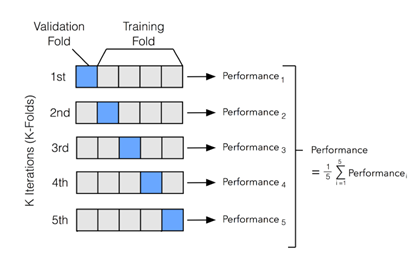

In [75]:
# 5.2 Cross validation strategy for the modeler
#      Perform startified k-fold cross-validation
#      There is also RepeatedStratifiedKFold() class
#      that will repeat startified k-fold N-number
#      of times
#      Instantiate cross-vlidation object
"""
Examples of Cross-validation strategies:
    i)   Leave one out  : Very time consuming
    ii)  Leave P out    : For example, leave 2 out
    iii) kfold          : k-equal random folds
    iv)  StratifiedKFold : kfolds + stratification
    v)   ShuffleSplit  => Generate n-numbers of userdefined pairs
                          of (train,test). For examples, in each
                          (train,test) pair, let number of rows
                          of 'test' data be 30% of train data

"""

cvStrategy = StratifiedKFold(
                             n_splits=3,
                             shuffle=True,
                             random_state=42
                            )

"\nExamples of Cross-validation strategies:\n    i)   Leave one out  : Very time consuming\n    ii)  Leave P out    : For example, leave 2 out\n    iii) kfold          : k-equal random folds\n    iv)  StratifiedKFold : kfolds + stratification\n    v)   ShuffleSplit  => Generate n-numbers of userdefined pairs\n                          of (train,test). For examples, in each\n                          (train,test) pair, let number of rows\n                          of 'test' data be 30% of train data\n\n"

#### Bayes tuner object

In [76]:
# 5.3 Bayesian object instantiation
#     For API, refer: https://scikit-optimize.github.io/#skopt.BayesSearchCV
#     For example: https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

start = time.time()
bayes_cv_tuner = BayesSearchCV(
                              estimator = pipe,    # rf, lgb, xgb, nn , pipeline etc--Black box
                              search_spaces = params,  # Specify params as required by the estimator
                              scoring = 'roc_auc',  # Input to Bayes function
                                                    # modeler should return this
                                                    # peformence metric
                              cv = cvStrategy,      # Optional. Determines the cross-validation splitting strategy.
                                                    #           Can be cross-validation generator or an iterable,
                                                    #           Possible inputs for cv are: - None, to use the default 3-fold cv,
                                                    #           - integer, to specify the number of folds in a (Stratified)KFold,
                                                    #           - An object to be used as a cross-validation generator.
                              n_jobs = 2,           # Start two parallel threads for processing
                              n_iter = 10,        # How many times to look for parameter sets
                              verbose = 1,
                              refit = True,       #  Refit the best estimator with the entire dataset
                              random_state = 42
                               )
end = time.time()
(end-start)/60

2.5192896525065104e-06

#### Begin tuning

In [77]:
# 5.4 Start learning using Bayes tuner

start = time.time()
result = bayes_cv_tuner.fit(
                            train_x,       # Note that we use normal train data
                            train_y,       #  rather than lgb train-data matrix
                            #callback=status_print
                           )

end = time.time()
(end - start)/60

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    7.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    4.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    8.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    3.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    8.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.4s finished


[LightGBM] [Warning] bagging_fraction is set=0.9674776711106569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9674776711106569
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8609791252746636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8609791252746636
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9674776711106569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9674776711106569
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8609791252746636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8609791252746636
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignor

0.7553601185480754

#### Results

In [78]:
# 6.0 So what are the results?
#      Use the following estimator in future
#      What parameters the best estimator was using?

best_params = pd.Series(bayes_cv_tuner.best_params_)
print(best_params)

# 6.1 Best auc score for the above estimator

print("\n\nBest score: ", np.round(bayes_cv_tuner.best_score_, 4))


lgb__bagging_fraction     0.967478
lgb__bagging_freq                9
lgb__boosting                 dart
lgb__feature_fraction     0.860979
lgb__learning_rate        0.534879
lgb__max_bin                   156
lgb__max_depth                   8
lgb__min_child_samples          18
lgb__min_child_weight      6.72156
lgb__n_estimators               98
lgb__num_leaves                 30
lgb__reg_alpha            0.852405
lgb__reg_lambda            1.59034
lgb__scale_pos_weight      4.49672
lgb__subsample_for_bin      342928
dtype: object


Best score:  0.9804


In [79]:
# 6.2 Summary of all models developed by Bayes process

allModels_summary = pd.DataFrame(bayes_cv_tuner.cv_results_)
allModels_summary.shape  # 50 X 26 ; 50 iterations

# 6.3
allModels_summary.head()

(10, 26)

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgb__bagging_fraction,param_lgb__bagging_freq,param_lgb__boosting,param_lgb__feature_fraction,param_lgb__learning_rate,param_lgb__max_bin,param_lgb__max_depth,param_lgb__min_child_samples,param_lgb__min_child_weight,param_lgb__n_estimators,param_lgb__num_leaves,param_lgb__reg_alpha,param_lgb__reg_lambda,param_lgb__scale_pos_weight,param_lgb__subsample_for_bin,params
0,0.972303,0.971574,0.967746,0.970541,0.001999,5,0.780756,0.378145,0.022572,0.006248,0.882021,8,gbdt,0.352640,0.218925,473,18,37,3.740170,82,27,1.385174e-08,1.370904e-07,6.688861,131156,"{'lgb__bagging_fraction': 0.8820207917706628, ..."
1,0.981035,0.982340,0.977917,0.980431,0.001856,1,4.624523,2.979596,0.035045,0.010345,0.967478,9,dart,0.860979,0.534879,156,8,18,6.721562,98,30,8.524050e-01,1.590337e+00,4.496724,342928,"{'lgb__bagging_fraction': 0.9674776711106569, ..."
2,0.952665,0.946298,0.945274,0.948079,0.003270,8,2.580701,1.478836,0.025732,0.007254,0.888967,9,dart,0.446666,0.023763,508,9,38,6.016064,99,33,2.711809e-06,2.367361e-07,5.585960,278139,"{'lgb__bagging_fraction': 0.8889665024602303, ..."
3,0.975458,0.971274,0.968668,0.971800,0.002797,4,1.314180,0.777748,0.025220,0.009816,0.962479,3,gbdt,0.742212,0.111200,186,38,44,9.207360,69,19,3.449623e-02,2.114410e-02,1.236578,485880,"{'lgb__bagging_fraction': 0.9624791976714727, ..."
4,0.977447,0.979402,0.973138,0.976662,0.002617,2,5.777725,3.849617,0.026366,0.009205,0.959911,5,gbdt,0.672571,0.642250,745,22,33,4.177755,83,26,8.740059e-02,1.165902e-06,3.383559,207155,"{'lgb__bagging_fraction': 0.9599106883214347, ..."


In [ ]:
####### I am done #############